In [1]:
!pip install gensim

# Setup and Initial Exploration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
import gensim.downloader as api

Matplotlib is building the font cache; this may take a moment.


# Load the dataset

In [4]:
df = pd.read_csv("NikeProductDescriptions.csv")

In [5]:
print(df.shape)
print(df.info())
print(df.describe())

(400, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Title                400 non-null    object
 1   Subtitle             400 non-null    object
 2   Product Description  400 non-null    object
dtypes: object(3)
memory usage: 9.5+ KB
None
                  Title       Subtitle  \
count               400            400   
unique              254            228   
top     Nike Sportswear  Women's Shoes   
freq                 41             34   

                                      Product Description  
count                                                 400  
unique                                                400  
top     It doesn't get more legendary than this. Desig...  
freq                                                    1  


# Text Processing

In [6]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\azizb\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


# Cleaning text - removing special characters

In [39]:
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = re.sub(r"[^a-zA-Z ]", "", text)  # Remove special characters
    words = text.lower().split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

df['Cleaned_Description'] = df['Product Description'].apply(lambda x: clean_text(str(x)))

# Filtering Subtitles

In [40]:
subtitles_to_keep = [
    "Men's Shoes", "Men's T-Shirt", "Women's Shoes", 
    "Skate Shoes", "Older Kids' T-Shirt"
]

df_filtered = df[df['Subtitle'].isin(subtitles_to_keep) |
                 df['Subtitle'].str.contains('Shorts', case=False, na=False)].copy()
df_filtered.loc[df_filtered['Subtitle'].str.contains('Shorts', case=False, na=False), 'Subtitle'] = 'Shorts'

print("Filtered Data Subtitles Distribution:")
print(df_filtered['Subtitle'].value_counts())

Filtered Data Subtitles Distribution:
Shorts                 45
Women's Shoes          34
Men's Shoes            31
Skate Shoes            22
Men's T-Shirt          14
Older Kids' T-Shirt     9
Name: Subtitle, dtype: int64


# Word Embedding - BoW, TF-IDF, Word2Vec, GloVe and PCA Visualistaion

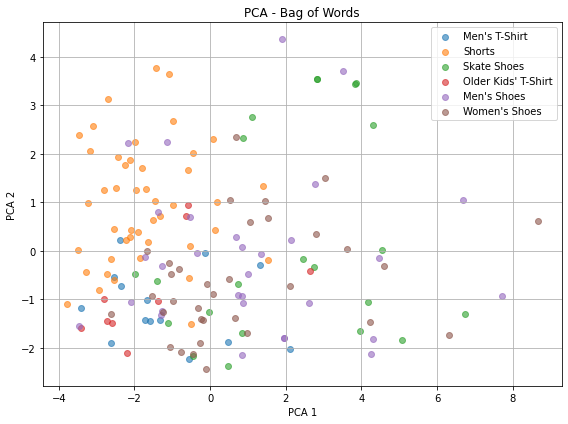

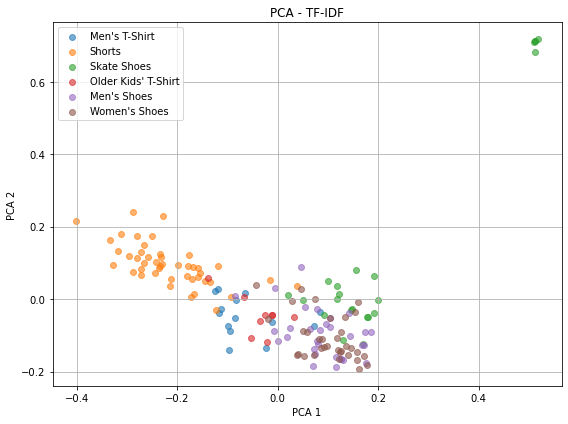

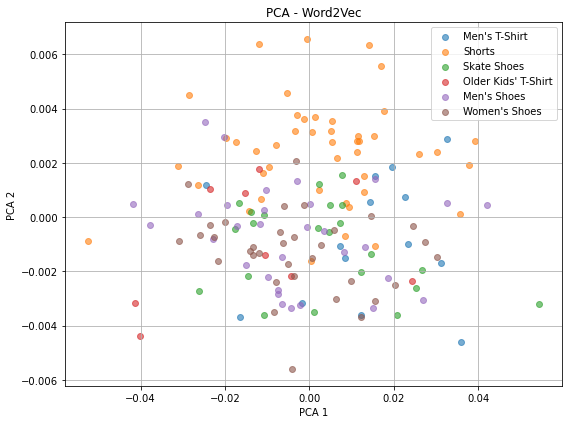

In [43]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

descriptions = df_filtered['Product Description'].astype(str)
labels = df_filtered['Subtitle']

# BOW
vectorizer_bow = CountVectorizer(max_features=1000)
X_bow = vectorizer_bow.fit_transform(descriptions).toarray()

# TF-IDF
vectorizer_tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer_tfidf.fit_transform(descriptions).toarray()

# PCA
pca = PCA(n_components=2)
X_bow_pca = pca.fit_transform(X_bow)
X_tfidf_pca = pca.fit_transform(X_tfidf)

def plot_pca(data, labels, title):
    plt.figure(figsize=(8,6))
    unique_labels = list(set(labels))
    for label in unique_labels:
        idx = np.where(labels == label)
        plt.scatter(data[idx, 0], data[idx, 1], label=label, alpha=0.6)
    plt.legend()
    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pca(X_bow_pca, labels.values, "PCA - Bag of Words")
plot_pca(X_tfidf_pca, labels.values, "PCA - TF-IDF")
from gensim.models import Word2Vec

tokenized = descriptions.str.lower().str.split()
w2v_model = Word2Vec(sentences=tokenized, vector_size=100, window=5, min_count=1, workers=4)

def avg_vec(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

X_w2v = np.array([avg_vec(tokens, w2v_model) for tokens in tokenized])
X_w2v_pca = PCA(n_components=2).fit_transform(X_w2v)

plot_pca(X_w2v_pca, labels.values, "PCA - Word2Vec")

# Comparison and Analysis

# Comparison of Embedding Methods
- **Bag of Words (BoW):** 
  - Captures word frequency but lacks semantic context.
  - Words are treated independently, so "shoe" and "shoes" are different.

- **TF-IDF (Term Frequency-Inverse Document Frequency):** 
  - Prioritizes important words but still ignores word order.
  - Useful for highlighting rare but significant words.

- **Word2Vec:** 
  - Captures semantic relationships between words using context.
  - Words with similar meanings (e.g., "shoe" and "sneaker") are close in the vector space.
  - Ideal for understanding relationships and similarities between words.

- **GloVe (Global Vectors):** 
  - A pre-trained model capturing global co-occurrences of words.
  - Balances semantic understanding with global context but may not capture specific contexts of the

# Best Method Choice
- Based on the PCA visualizations and semantic understanding, **Word2Vec** provides the best performance.
- It captures the meaning of words and their relationships, making it the most accurate for this dataset.
- This is evident in the clear clustering of similar product types using Word2Vec.